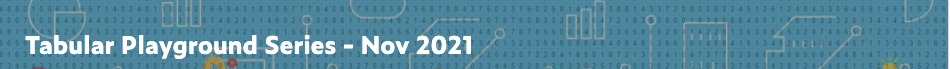

### Copy Files Locally

In [ ]:
# from google.colab import drive

# drive.mount("/content/drive")

In [ ]:
# %%bash
# if ! [ -e /content/test.feather ] || ! [ -e /content/train.feather ]; then
#   cp /content/drive/MyDrive/Colab\ Notebooks/TPS\ 2021-10/{train,test}.feather \
#       /content/drive/MyDrive/Colab\ Notebooks/TPS\ 2021-10/sample_submission.csv /content/
# fi

### Install Packages

In [ ]:
# !pip install catboost
# !pip install optuna
# # !pip install pytorch_tabnet
# !pip install BorutaShap

# # plotly is old in Colab
# !pip install plotly -U

# # Add GPU support
# !pip install lightgbm --install-option=--gpu -U

### Initialization

In [1]:
from IPython.core.interactiveshell import InteractiveShell

InteractiveShell.ast_node_interactivity = "all"
import os
import pandas as pd
from datetime import datetime
import numpy as np
import joblib
import matplotlib.pyplot as plt

%matplotlib inline
from collections import Counter
import math
import seaborn as sns

sns.set_style("ticks")
from sklearn.cluster import KMeans
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import SimpleImputer, IterativeImputer, KNNImputer
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.metrics import roc_auc_score, accuracy_score
from sklearn.model_selection import (
    train_test_split,
    StratifiedKFold,
    GridSearchCV,
    RandomizedSearchCV,
    StratifiedShuffleSplit,
    StratifiedKFold,
)
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import (
    MinMaxScaler,
    StandardScaler,
    RobustScaler,
    PowerTransformer,
    LabelEncoder,
)
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier
import optuna
import functools
import warnings
import gc
import platform

warnings.filterwarnings("ignore")

running_on = platform.system()

if running_on == "Windows":
    drive_path = r"C:\Users\pmm\My Drive\Colab Notebooks\TPS 2021-11"
elif running_on == "Darwin":
    drive_path = "/Users/pmm/My Drive/Colab Notebooks/TPS 2021-11"
elif "google.colab" in str(get_ipython()):
    drive_path = "/content"

path = drive_path
now = lambda: datetime.now().strftime("%Y-%m-%dT%Hh%Mm%Ss")

In [ ]:
# from torch import cuda

# try:
#     my_gpu = {cuda.get_device_name(0)}
# except:
#     my_gpu = "not found (sad trombone)"

# print(f"GPU is {my_gpu}")

In [2]:
train_data = pd.read_feather(os.path.join(path, "train.feather")).drop(
    columns=["id"]
)
test_data = pd.read_feather(os.path.join(path, "test.feather")).drop(
    columns=["id"]
)

In [3]:
def reduce_memory_usage(df, verbose=True):
    numerics = [
        "int8",
        "int16",
        "int32",
        "int64",
        "float16",
        "float32",
        "float64",
    ]
    start_mem = df.memory_usage().sum() / 1024 ** 2

    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == "int":
                if (
                    c_min > np.iinfo(np.int8).min
                    and c_max < np.iinfo(np.int8).max
                ):
                    df[col] = df[col].astype(np.int8)
                elif (
                    c_min > np.iinfo(np.int16).min
                    and c_max < np.iinfo(np.int16).max
                ):
                    df[col] = df[col].astype(np.int16)
                elif (
                    c_min > np.iinfo(np.int32).min
                    and c_max < np.iinfo(np.int32).max
                ):
                    df[col] = df[col].astype(np.int32)
                elif (
                    c_min > np.iinfo(np.int64).min
                    and c_max < np.iinfo(np.int64).max
                ):
                    df[col] = df[col].astype(np.int64)
            else:
                if (
                    c_min > np.finfo(np.float16).min
                    and c_max < np.finfo(np.float16).max
                ):
                    #                     df[col] = df[col].astype(np.float16)
                    df[col] = df[col].astype(np.float32)
                elif (
                    c_min > np.finfo(np.float32).min
                    and c_max < np.finfo(np.float32).max
                ):
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
    end_mem = df.memory_usage().sum() / 1024 ** 2

    if verbose:
        print(
            "Mem. usage decreased to {:.2f} Mb ({:.1f}% reduction)".format(
                end_mem, 100 * (start_mem - end_mem) / start_mem
            )
        )

    return df

In [4]:
reduced_train_data = reduce_memory_usage(train_data, verbose=True)
reduced_test_data = reduce_memory_usage(test_data, verbose=True)

Mem. usage decreased to 229.45 Mb (50.4% reduction)
Mem. usage decreased to 205.99 Mb (50.0% reduction)


### Scaling

In [ ]:
# # scaler = StandardScaler()
# scaler = RobustScaler()
# col_names = test_data.columns
# train_target = train_data["target"]
# scaled_train_data = pd.concat(
#     [
#         pd.DataFrame(
#             scaler.fit_transform(train_data.drop(columns=["target"])),
#             columns=col_names,
#         ),
#         train_target,
#     ],
#     axis=1,
# )
# scaled_test_data = pd.DataFrame(
#     scaler.transform(test_data), columns=col_names
# )

In [5]:
# scaler = StandardScaler()
scaler = RobustScaler()
col_names = reduced_test_data.columns
train_target = reduced_train_data["target"]
scaled_train_data = pd.concat(
    [
        pd.DataFrame(
            scaler.fit_transform(reduced_train_data.drop(columns=["target"])),
            columns=col_names,
        ),
        train_target,
    ],
    axis=1,
)
scaled_test_data = pd.DataFrame(
    scaler.transform(reduced_test_data), columns=col_names
)

In [ ]:
scaled_train_data.head()

### Build X, y

In [6]:
X = scaled_train_data
X_test = scaled_test_data
# X = reduced_train_data
# X_test = reduced_test_data
# X = train_data
# X_test = test_data
# X = imp_train_data
# X_test = imp_test_data
y = X["target"]
X = X.drop(["target"], axis=1)

X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, shuffle=True, stratify=y, random_state=53
)
# X_train, X_valid, y_train, y_valid = train_test_split(X, y, random_state=53)

### Boruta-SHAP

In [ ]:
# from BorutaShap import BorutaShap, load_data

# X_train, X_val, y_train, y_val = train_test_split(
#     X, y, test_size=0.2, shuffle=True, stratify=y, random_state=53
# )

# params = {
#     "learning_rate": 0.021,
#     "l2_leaf_reg": 30,
#     "verbose": False,
#     "random_strength": 0.6,
#     "bagging_temperature": 0.1,
#     "task_type": "CPU",
#     # "task_type": "GPU",
#     # "bootstrap_type": "Poisson",
#     "subsample": 0.253214900809937,
#     "max_depth": 6,
#     "n_estimators": 7778,
#     "max_bin": 2470,
#     "min_data_in_leaf": 82,
# }

# model = CatBoostClassifier(**params)

# Feature_Selector = BorutaShap(
#     model=model, importance_measure="shap", classification=True,
# )

# Feature_Selector.fit(
#     X=X_train,
#     y=y_train,
#     n_trials=50,
#     sample=False,
#     train_or_test="test",
#     normalize=True,
#     verbose=True,
# )

In [ ]:
# # Returns Boxplot of features
# Feature_Selector.plot(which_features="all")

In [ ]:
# # Return a subset of the original data with the selected features
# Feature_Selector.Subset()

In [ ]:
# raise  # a little hell

### K-means - cluster sizing

In [ ]:
# Sum_of_squared_distances = []
# K = range(1,30)
# for k in K:
#     print(f"Fit {k}: {now()}")
#     km = KMeans(n_clusters=k)
#     km = km.fit(X_train)
#     Sum_of_squared_distances.append(km.inertia_)

In [ ]:
# plt.plot(K, Sum_of_squared_distances, 'bx-')
# plt.xlabel('k')
# plt.ylabel('Sum_of_squared_distances')
# plt.title('Elbow Method For Optimal k')
# plt.show()

### K-Means

### Linear Discriminant Analysis Optuna

In [7]:
def objective(trial, data=X, target=y):
    #     X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, shuffle=True, stratify=y, random_state=53)
    sss = StratifiedShuffleSplit(n_splits=10, test_size=0.2, random_state=53)
    sss.get_n_splits(X, y)

    params = {
        "solver": trial.suggest_categorical("solver", ["eigen"]),
        "shrinkage": trial.suggest_categorical(
            "shrinkage",
            [1e-7, 1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1],
        ),
        
    }

    auc_scores = []
    model = LinearDiscriminantAnalysis(**params)
    for train_index, test_index in sss.split(X, y):
        X_train, X_val = X.loc[train_index], X.loc[test_index]
        y_train, y_val = y.loc[train_index], y.loc[test_index]

        model.fit(X_train, y_train)
        y_pred = model.predict_proba(X_val)[:, 1]
        auc_scores.append(roc_auc_score(y_val, y_pred))

        return round(np.mean(auc_scores), 6)

In [8]:
study_name = "lda53"
study = optuna.create_study(
    study_name=study_name,
    direction="maximize",
    storage=f"sqlite:///{drive_path}/{now()}_{study_name}.db",
)
study.optimize(
    objective, n_trials=100, gc_after_trial=True,
)


print("Best trial:", study.best_trial.params)
print("Best value:", study.best_value)

[I 2021-11-10 13:47:34,378] A new study created in RDB with name: lda53
[I 2021-11-10 13:47:39,910] Trial 0 finished with value: 0.74751 and parameters: {'solver': 'eigen', 'shrinkage': 1e-06}. Best is trial 0 with value: 0.74751.
[I 2021-11-10 13:47:44,519] Trial 1 finished with value: 0.747511 and parameters: {'solver': 'eigen', 'shrinkage': 1e-05}. Best is trial 1 with value: 0.747511.
[I 2021-11-10 13:47:48,971] Trial 2 finished with value: 0.74751 and parameters: {'solver': 'eigen', 'shrinkage': 1e-06}. Best is trial 1 with value: 0.747511.
[I 2021-11-10 13:47:52,977] Trial 3 finished with value: 0.747517 and parameters: {'solver': 'eigen', 'shrinkage': 0.0001}. Best is trial 3 with value: 0.747517.
[I 2021-11-10 13:47:57,253] Trial 4 finished with value: 0.747512 and parameters: {'solver': 'eigen', 'shrinkage': 0.01}. Best is trial 3 with value: 0.747517.
[I 2021-11-10 13:48:01,409] Trial 5 finished with value: 0.74751 and parameters: {'solver': 'eigen', 'shrinkage': 1e-07}. Best

Best trial: {'shrinkage': 0.001, 'solver': 'eigen'}
Best value: 0.747574


In [9]:
study.best_params
# best_params = {
#     'max_depth': 8,
#     'learning_rate': 0.016,
#     'n_estimators': 6382,
#     'max_bin': 2886,
#     'min_data_in_leaf': 133,
#     'l2_leaf_reg': 28,
#     'subsample': 0.6940215099723984,
#     'bagging_temperature': 0.2,
#     'random_strength': 0.1
# } # Best is trial 42 with value: 0.857054.

{'shrinkage': 0.001, 'solver': 'eigen'}

In [10]:
model = LinearDiscriminantAnalysis(
    **study.best_params,
    #     **best_params,
)

model.fit(X, y)

LinearDiscriminantAnalysis(shrinkage=0.001, solver='eigen')

### Logistic Regression Optuna

In [ ]:
# def objective(trial, data=X, target=y):
#     #     X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, shuffle=True, stratify=y, random_state=53)
#     sss = StratifiedShuffleSplit(n_splits=10, test_size=0.2, random_state=53)
#     sss.get_n_splits(X, y)

#     params = {
#         "solver": trial.suggest_categorical("solver", ["saga"]),
#         "penalty": trial.suggest_categorical(
#             "penalty", ["elasticnet", "l1", "l2", "none"]
#         ),
#         "C": trial.suggest_loguniform('C', 1e-5, 1e2),
#         "l1_ratio": trial.suggest_float("l1_ratio", 1e-9, 1.0, log=True),
#         "n_jobs": -1,
#         "random_state": 53,
#     }

#     auc_scores = []
#     model = LogisticRegression(**params)
#     for train_index, test_index in sss.split(X, y):
#         X_train, X_val = X.loc[train_index], X.loc[test_index]
#         y_train, y_val = y.loc[train_index], y.loc[test_index]

#         model.fit(X_train, y_train)
#         y_pred = model.predict_proba(X_val)[:, 1]
#         auc_scores.append(roc_auc_score(y_val, y_pred))

#         return round(np.mean(auc_scores), 6)

In [ ]:
# study_name = "lr53"
# study = optuna.create_study(
#     study_name=study_name,
#     direction="maximize",
#     storage=f"sqlite:///{drive_path}/{now()}_{study_name}.db",
# )
# study.optimize(
#     objective, n_trials=100, gc_after_trial=True,
# )


# print("Best trial:", study.best_trial.params)
# print("Best value:", study.best_value)

In [ ]:
# study.best_params
# # best_params = {
# #     'max_depth': 8,
# #     'learning_rate': 0.016,
# #     'n_estimators': 6382,
# #     'max_bin': 2886,
# #     'min_data_in_leaf': 133,
# #     'l2_leaf_reg': 28,
# #     'subsample': 0.6940215099723984,
# #     'bagging_temperature': 0.2,
# #     'random_strength': 0.1
# # } # Best is trial 42 with value: 0.857054.

In [ ]:
# model = LogisticRegression(
#     **study.best_params,
#     #     **best_params,
# )

# model.fit(X, y)

### HistGradientBoostingClassifier Optuna

In [ ]:
# def objective(trial, data=X, target=y):
#     X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, shuffle=True, stratify=y, random_state=53)

#     params = {
#         "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.3),
#         "max_iter": trial.suggest_int("max_iter", 40, 2000, step=20),
#         "max_leaf_nodes": trial.suggest_int("max_leaf_nodes", 20, 3000, step=20),
#         'max_depth': trial.suggest_int('max_depth', 2, 20),
#         "min_samples_leaf": trial.suggest_int("min_samples_leaf", 200, 10000, step=100),
#         "l2_regularization": trial.suggest_float("l2_regularization", 0, 100),
#         "max_bins": trial.suggest_int('max_bins', 2, 255),
#         'random_state': 53,
#     }

#     model = HistGradientBoostingClassifier(**params)
#     model.fit(X_train, y_train)
#     y_pred = model.predict_proba(X_val)[:,1]

#     return round(roc_auc_score(y_val, y_pred), 6)

In [ ]:
# study = optuna.create_study(direction="maximize")
# study.optimize(objective, n_trials=100)

In [ ]:
# study.optimize(objective, n_trials=100)

In [ ]:
# # study.best_params
# best_params = {
#     'learning_rate': 0.07377316211051196,
#     'max_iter': 1940,
#     'max_leaf_nodes': 540,
#     'max_depth': 3,
#     'min_samples_leaf': 2400,
#     'l2_regularization': 82.0057778662081,
#     'max_bins': 175
# } # Best is trial 192 with value: 0.85668.

In [ ]:
# model = HistGradientBoostingClassifier(
#     random_state=53,
#     **best_params,
#     # **study.best_params,
# )
# model.fit(X, y)

### CatBoost Optuna

In [ ]:
# def objective(trial, data=X, target=y):
#     #     X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, shuffle=True, stratify=y, random_state=53)
#     # splitter = StratifiedShuffleSplit(n_splits=10, test_size=0.2, random_state=37)
#     # splitter.get_n_splits(X, y)
#     splitter = StratifiedKFold(n_splits=5, shuffle=True, random_state=53)
#     splitter.get_n_splits(X, y)

#     params = {
#         "max_depth": trial.suggest_int("max_depth", 1, 6),
#         "learning_rate": trial.suggest_discrete_uniform(
#             "learning_rate", 0.001, 0.3, 0.005
#         ),
#         "n_estimators": trial.suggest_int("n_estimators", 4000, 10000),
#         "max_bin": trial.suggest_int("max_bin", 600, 3000),
#         "subsample": trial.suggest_int("min_data_in_leaf", 1, 300),
#         "l2_leaf_reg": trial.suggest_int("l2_leaf_reg", 1, 100),
#         "subsample": trial.suggest_float("subsample", 0.1, 0.8),
#         "bagging_temperature": trial.suggest_discrete_uniform(
#             "bagging_temperature", 0.1, 1, 0.1
#         ),
#         "random_strength": trial.suggest_discrete_uniform(
#             "random_strength", 0.1, 1, 0.1
#         ),
#         # "boosting_type": "Plain",
#         # "gpu_cat_features_storage": "CpuPinnedMemory",
#         # "max_ctr_complexity": 1,
#         # "gpu_ram_part": 0.5,
#         "random_seed": 37,
#         "task_type": "CPU",
#         # "task_type": "GPU",
#         # "bootstrap_type": "Poisson",
#         "loss_function": "Logloss",
#         "eval_metric": "AUC",
#         "logging_level": "Silent",
#     }

#     auc_scores = []
#     model = CatBoostClassifier(**params)
#     for train_index, test_index in splitter.split(X, y):
#         X_train, X_val = X.loc[train_index], X.loc[test_index]
#         y_train, y_val = y.loc[train_index], y.loc[test_index]

#         model.fit(X_train, y_train)
#         y_pred = model.predict_proba(X_val)[:, 1]
#         auc_scores.append(roc_auc_score(y_val, y_pred))

#         return round(np.mean(auc_scores), 6)

In [ ]:
# study_name = "cb37"
# db_file = os.path.join(drive_path, f"{now()}_{study_name}.db")
# study = optuna.create_study(
#     study_name=study_name,
#     direction="maximize",
#     storage=f"sqlite:///{db_file}",
# )
# study.optimize(
#     objective, n_trials=100,)

In [ ]:
# study.best_params
# # best_params = {
# #     'max_depth': 8,
# #     'learning_rate': 0.016,
# #     'n_estimators': 6382,
# #     'max_bin': 2886,
# #     'min_data_in_leaf': 133,
# #     'l2_leaf_reg': 28,
# #     'subsample': 0.6940215099723984,
# #     'bagging_temperature': 0.2,
# #     'random_strength': 0.1
# # } # Best is trial 42 with value: 0.857054.

In [ ]:
# # model = CatBoostClassifier(task_type="GPU", **study.best_params)
# model = CatBoostClassifier(
#     # task_type="GPU",
#     # bootstrap_type="Poisson",
#     task_type="CPU",
#     verbose=False,
#     random_seed=37,
#     **study.best_params,
#     #     **best_params,
# )

# model.fit(X, y)

### LightGBM Optuna

In [ ]:
# import lightgbm as lgb

# def objective(trial, data=X, target=y):
#     #     X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, shuffle=True, stratify=y, random_state=61)
#     # sss = StratifiedShuffleSplit(n_splits=10, test_size=0.2, random_state=37)
#     # sss.get_n_splits(X, y)
#     skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=53)
#     skf.get_n_splits(X, y)

#     params = {
#         "n_estimators": trial.suggest_int("n_estimators", 1000, 10000, step=100),
#         "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.3),
#         "num_leaves": trial.suggest_int("num_leaves", 20, 3000, step=20),
#         "max_depth": trial.suggest_int("max_depth", 3, 12),
#         "min_child_samples": trial.suggest_int(
#             "min_child_samples", 200, 10000, step=100
#         ),
#         "reg_alpha": trial.suggest_int("reg_alpha", 0, 100, step=5),
#         "reg_lambda": trial.suggest_int("reg_lambda", 0, 100, step=5),
#         "min_split_gain": trial.suggest_float("min_split_gain", 0, 15),
#         "subsample": trial.suggest_float("subsample", 0.2, 0.95, step=0.1),
#         "subsample_freq": trial.suggest_categorical("subsample_freq", [1]),
#         "colsample_bytree": trial.suggest_float(
#             "colsample_bytree", 0.2, 0.95, step=0.1
#         ),
#         "random_state": 61,
#         "device_type": "gpu",
#         "gpu_platform_id": 0,
#         "gpu_device_id": 0,
#         "verbose": -1,
#     }
# #     params["early_stopping_round"] = int(params["n_estimators"] * 0.1)

# #     train_data = lgb.Dataset(X_train, label=y_train)
# #     val_data = lgb.Dataset(X_val, label=y_val, reference=train_data)

#     auc_scores = []
#     model = LGBMClassifier(**params)
#     for train_index, test_index in skf.split(X, y):
#         X_train, X_val = X.loc[train_index], X.loc[test_index]
#         y_train, y_val = y.loc[train_index], y.loc[test_index]

#         model.fit(X_train, y_train, eval_metric="auc")
#         y_pred = model.predict_proba(X_val)[:, 1]
#         auc_scores.append(roc_auc_score(y_val, y_pred))

#         return round(np.mean(auc_scores), 6)

In [ ]:
# study_name = "lbg61"
# db_file = os.path.join(drive_path, f"{now()}_{study_name}.db")
# study = optuna.create_study(
#     study_name=study_name,
#     direction="maximize",
#     storage=f"sqlite:///{db_file}",
# )
# study.optimize(objective, n_trials=100)

In [ ]:
# study.best_params
# # best_params = {
# #     'n_estimators': 10000,
# #     'learning_rate': 0.016840983742535055,
# #     'num_leaves': 2560,
# #     'max_depth': 5,
# #     'min_child_samples': 1100,
# #     'reg_alpha': 30,
# #     'reg_lambda': 55,
# #     'min_split_gain': 5.283598257688793,
# #     'subsample': 0.7,
# #     'subsample_freq': 1,
# #     'colsample_bytree': 0.2
# # } # Best is trial 99 with value: 0.857347.

In [ ]:
# model = LGBMClassifier(
#     device_type="gpu",
#     gpu_platform_id=0,
#     gpu_device_id=0,
#     verbose=-1,
#     random_state=61,
#     #     **best_params,
#     **study.best_params,
# )
# model.fit(X, y)

### XGBoost Optuna

In [ ]:
# def objective(trial, data=X, target=y):
#     #     X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, shuffle=True, stratify=y, random_state=37)
#     #     sss = StratifiedShuffleSplit(n_splits=10, test_size=0.2, random_state=23)
#     #     sss.get_n_splits(X, y)
#     skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=53)
#     skf.get_n_splits(X, y)

#     params = {
#         # imbalanced classes
#         # "scale_pos_weight": trial.suggest_int("scale_pos_weight", 1, 100),
#         "n_estimators": trial.suggest_int("n_estimators", 1000, 10000),
#         "max_depth": trial.suggest_int("max_depth", 1, 20),
#         "min_child_weight": trial.suggest_int("min_child_weight", 1, 20),
#         "learning_rate": trial.suggest_discrete_uniform(
#             "learning_rate", 0.01, 0.1, 0.01
#         ),
#         "subsample": trial.suggest_discrete_uniform(
#             "subsample", 0.5, 0.9, 0.1
#         ),
#         "colsample_bytree": trial.suggest_discrete_uniform(
#             "colsample_bytree", 0.5, 0.9, 0.1
#         ),
#         "gamma": trial.suggest_discrete_uniform("gamma", 1, 9, 2),
#         "random_state": 53,
#         "tree_method": "gpu_hist",
#         "objective": "binary:logistic",
#         "eval_metric": "logloss",
#         "n_jobs": -1,
#         #         "silent": True,
#     }

#     auc_scores = []
#     model = XGBClassifier(**params)
#     for train_index, test_index in skf.split(X, y):
#         X_train, X_val = X.loc[train_index], X.loc[test_index]
#         y_train, y_val = y.loc[train_index], y.loc[test_index]

#         model.fit(X_train, y_train)
#         y_pred = model.predict_proba(X_val)[:, 1]
#         auc_scores.append(roc_auc_score(y_val, y_pred))

#         return round(np.mean(auc_scores), 6)

In [ ]:
# study_name = "xgb53"
# db_file = os.path.join(drive_path, f"{now()}_{study_name}.db")
# study = optuna.create_study(
#     study_name=study_name,
#     direction="maximize",
#     storage=f"sqlite:///{db_file}",
# )

# study.optimize(objective, n_trials=100)

In [ ]:
# study.best_params
# # best_params = {
# # 'n_estimators': 8989,
# # 'max_depth': 4,
# # 'min_child_weight': 5,
# # 'learning_rate': 0.01,
# # 'subsample': 0.5,
# # 'colsample_bytree': 0.9,
# # 'gamma': 1.0
# # } # Best is trial 71 with value: 0.85809.

In [ ]:
# model = XGBClassifier(
#     random_state=53,
#     tree_method="gpu_hist",
#     objective="binary:logistic",
#     eval_metric="logloss",
#     #     silent=True,
#     **study.best_params,
#     # **best_params,
# )
# # model = XGBClassifier(**best_params)
# model.fit(X, y)

### Results

In [11]:
model_name = type(model).__name__
submission_file = f"{drive_path}/submission_{model_name}_{now()}.csv"
y_pred = model.predict_proba(X_test)
submission = pd.read_csv(f"{path}/sample_submission.csv")
submission["target"] = y_pred[:, 1]
submission.to_csv(submission_file, index=False)

In [12]:
model_params = model.get_params()
val_auc = study.best_value
timestamp = datetime.now().strftime("%Y-%m-%dT%H:%M:%S")
exp_f = os.path.join(drive_path, "Experiments.csv")
cols = ["date", "model", "params", "val_auc", "test_auc"]

print("test auc:")
test_auc = float(input())

experiment = pd.DataFrame(
    [[timestamp, model_name, model_params, val_auc, test_auc]], columns=cols,
)

if os.path.exists(exp_f):
    experiments = pd.read_csv(exp_f)
else:
    experiments = pd.DataFrame(columns=cols)

experiments = pd.concat([experiments, experiment], ignore_index=True)
experiments.to_csv(exp_f, index=False)

test auc:


 0
